In [7]:
# Ensure the module is automatically reloaded when rerunning the import command.
%load_ext autoreload
%autoreload 2

import piv_functions as piv
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
directory = 'PIVimages/commercialflow/'
prefix = None
type = 'png'
images = piv.read_image_directory(directory, prefix, type)

100%|██████████| 128/128 [00:00<00:00, 6558.08it/s]


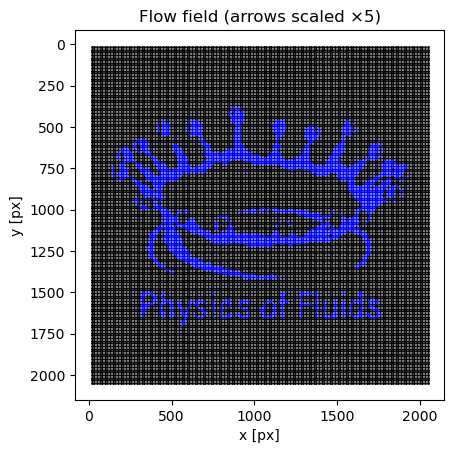

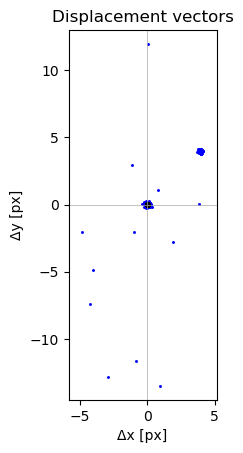

In [24]:
plot_params = {'arrow_scale':            5,
               'plot_windows':           False,
               'zero_displ_thr':         100,
               'highlight_radius_range': [0.1, np.inf],
               'highlight_angle_range':  [-np.pi, np.pi]}

displacements, coordinates = piv.simple_piv(images, (16, 16), plot=True, plt_flow_params=plot_params,plt_disp_params=plot_params)